# Verify assembled data
Quick checks to confirm photometry (and behaviour) data extraction matches the original notebooks.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill

DATAFOLDER = Path("..//data")

# Load assembled data — change filename if needed
with open(DATAFOLDER / "assembled_data.pickle", "rb") as f:
    data = dill.load(f)

x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_behav = data["snips_behav"]
params = data["params"]

print(f"snips_photo shape: {snips_photo.shape}")
print(f"snips_behav shape: {snips_behav.shape}")
print(f"x_array shape:     {x_array.shape}")
print(f"\nColumns: {x_array.columns.tolist()}")
print(f"\nConditions: {x_array.condition.unique()}")
print(f"Infusion types: {x_array.infusiontype.unique()}")
print(f"Rats: {x_array.id.unique()}")

snips_photo shape: (1911, 200)
snips_behav shape: (1911, 200)
x_array shape:     (1911, 11)

Columns: ['trial', 'id', 'condition', 'infusiontype', 'sex', 'cluster_photo', 'clusterness_photo', 'euclidean_diff', 'auc_snips', 'auc_vel', 'time_moving']

Conditions: ['deplete' 'replete']
Infusion types: ['10NaCl' '45NaCl']
Rats: ['PB23' 'PB24' 'PB33' 'PB39' 'PB44' 'PB61' 'PB62' 'PB64' 'PB70' 'PB391'
 'PB26' 'PB27' 'PB30' 'PB31' 'PB46' 'PB48' 'PB71' 'PB72' 'PB73' 'PB75']


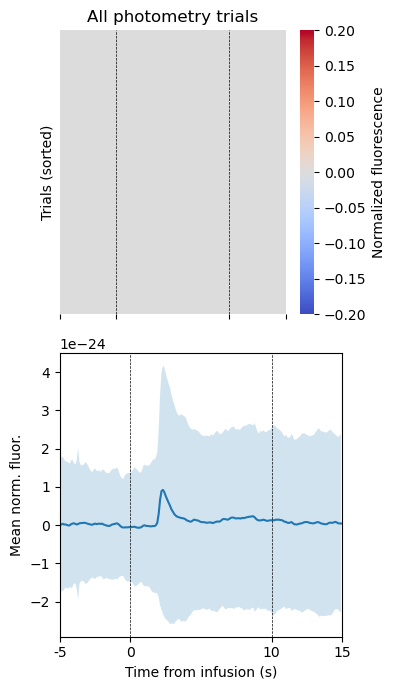

In [2]:
# ── Photometry heatmap + mean trace (matches make_tsplot from notebook) ──

framerate = 10
pre_window_size = int(params["photo_pre_seconds"] * framerate)  # 50
window_size = params["photo_bins"]  # 200
frames_for_infusion = 10 * framerate  # 100

# Sort by mean response during infusion (as in notebook)
sortwindow = [pre_window_size, pre_window_size + frames_for_infusion]
sortresponse = np.argsort(np.mean(snips_photo[:, sortwindow[0]:sortwindow[1]], axis=1))[::-1]

cmax = 0.2

f, axs = plt.subplots(nrows=2, figsize=(4, 7), sharex=True)

# Heatmap
sns.heatmap(snips_photo[sortresponse, :],
            ax=axs[0],
            cmap="coolwarm",
            vmin=-cmax, vmax=cmax,
            cbar_kws={"label": "Normalized fluorescence"})
axs[0].axvline(pre_window_size, linestyle="--", color="k", linewidth=0.5)
axs[0].axvline(pre_window_size + frames_for_infusion, linestyle="--", color="k", linewidth=0.5)
axs[0].set_ylabel("Trials (sorted)")
axs[0].set_yticks([])
axs[0].set_title("All photometry trials")

# Mean ± SD trace
mean = np.mean(snips_photo, axis=0)
sd = np.std(snips_photo, axis=0)
x = np.arange(window_size)
axs[1].fill_between(x, mean - sd, mean + sd, alpha=0.2)
axs[1].plot(x, mean)
axs[1].axvline(pre_window_size, linestyle="--", color="k", linewidth=0.5)
axs[1].axvline(pre_window_size + frames_for_infusion, linestyle="--", color="k", linewidth=0.5)
axs[1].set_ylabel("Mean norm. fluor.")

# x-axis labels in seconds
tick_positions = [0, pre_window_size, pre_window_size + frames_for_infusion, window_size]
tick_labels = [str(int((t - pre_window_size) / framerate)) for t in tick_positions]
axs[1].set_xticks(tick_positions)
axs[1].set_xticklabels(tick_labels)
axs[1].set_xlabel("Time from infusion (s)")

f.tight_layout()
plt.show()

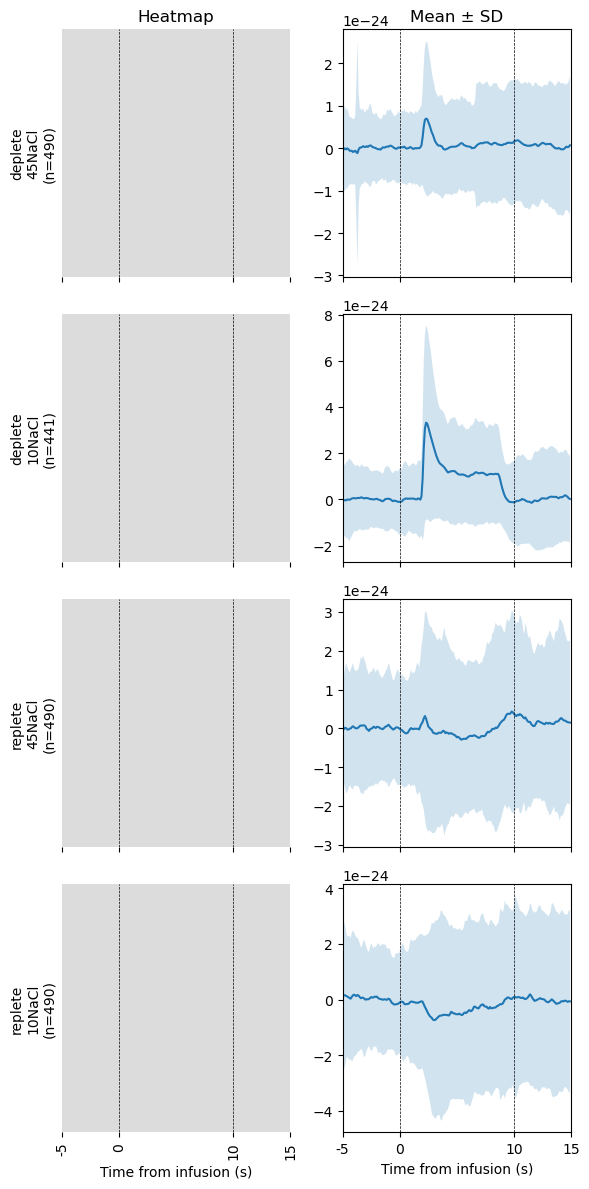

In [3]:
# ── Split by condition to check individual heatmaps ──

conditions = [("deplete", "45NaCl"), ("deplete", "10NaCl"), ("replete", "45NaCl"), ("replete", "10NaCl")]

f, axs = plt.subplots(nrows=len(conditions), ncols=2, figsize=(6, 3 * len(conditions)), sharex=True)

for i, (cond, inf) in enumerate(conditions):
    mask = (x_array.condition == cond) & (x_array.infusiontype == inf)
    subset = snips_photo[mask.values]
    
    if len(subset) == 0:
        axs[i, 0].text(0.5, 0.5, "No data", ha="center", va="center", transform=axs[i, 0].transAxes)
        axs[i, 0].set_ylabel(f"{cond}\n{inf}")
        continue
    
    sort_idx = np.argsort(np.mean(subset[:, sortwindow[0]:sortwindow[1]], axis=1))[::-1]
    
    sns.heatmap(subset[sort_idx], ax=axs[i, 0], cmap="coolwarm", vmin=-cmax, vmax=cmax, cbar=False)
    axs[i, 0].axvline(pre_window_size, linestyle="--", color="k", linewidth=0.5)
    axs[i, 0].axvline(pre_window_size + frames_for_infusion, linestyle="--", color="k", linewidth=0.5)
    axs[i, 0].set_ylabel(f"{cond}\n{inf}\n(n={len(subset)})")
    axs[i, 0].set_yticks([])
    
    mean = np.mean(subset, axis=0)
    sd = np.std(subset, axis=0)
    axs[i, 1].fill_between(x, mean - sd, mean + sd, alpha=0.2)
    axs[i, 1].plot(x, mean)
    axs[i, 1].axvline(pre_window_size, linestyle="--", color="k", linewidth=0.5)
    axs[i, 1].axvline(pre_window_size + frames_for_infusion, linestyle="--", color="k", linewidth=0.5)

for ax in axs[-1, :]:
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.set_xlabel("Time from infusion (s)")

axs[0, 0].set_title("Heatmap")
axs[0, 1].set_title("Mean ± SD")
f.tight_layout()
plt.show()

In [4]:
# ── Compare with original notebook data if available ──

original_file = DATAFOLDER / "bazzino_data.pickle"
if original_file.exists():
    with open(original_file, "rb") as f:
        orig = dill.load(f)
    
    orig_snips = orig["snips_photo"]
    orig_x = orig["x_array"]
    
    print(f"Original snips_photo shape: {orig_snips.shape}")
    print(f"New snips_photo shape:      {snips_photo.shape}")
    print(f"Original x_array shape:     {orig_x.shape}")
    print(f"New x_array shape:          {x_array.shape}")
    
    if orig_snips.shape == snips_photo.shape:
        diff = np.abs(orig_snips - snips_photo)
        print(f"\nMax absolute difference: {diff.max():.6f}")
        print(f"Mean absolute difference: {diff.mean():.6f}")
        if diff.max() < 1e-6:
            print("✓ Photometry data matches original exactly!")
        else:
            print("✗ Differences found — check extraction parameters")
    else:
        print("\nShapes differ — checking overlap by merging x_arrays...")
        common_cols = ["trial", "id", "condition", "infusiontype"]
        merged = pd.merge(
            x_array[common_cols].assign(_new_idx=np.arange(len(x_array))),
            orig_x[common_cols].reset_index(drop=True).assign(_orig_idx=np.arange(len(orig_x))),
            on=common_cols, how="inner"
        )
        print(f"  Common trials: {len(merged)}")
        print(f"  Only in new: {len(x_array) - len(merged)}")
        print(f"  Only in original: {len(orig_x) - len(merged)}")
else:
    print("No original bazzino_data.pickle found for comparison, skipping.")

Original snips_photo shape: (1960, 200)
New snips_photo shape:      (1911, 200)
Original x_array shape:     (1960, 4)
New x_array shape:          (1911, 11)

Shapes differ — checking overlap by merging x_arrays...
  Common trials: 1911
  Only in new: 0
  Only in original: 49
